In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip drive/MyDrive/dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset_zurich/train/merger/587739097519292568.jpeg  
  inflating: dataset_zurich/train/merger/587736942527643944.jpeg  
  inflating: dataset_zurich/train/merger/588007004191588455.jpeg  
  inflating: dataset_zurich/train/merger/587738953106849840.jpeg  
  inflating: dataset_zurich/train/merger/587739721898328168.jpeg  
  inflating: dataset_zurich/train/merger/588007004191785072.jpeg  
  inflating: dataset_zurich/train/merger/588023045865603121.jpeg  
  inflating: dataset_zurich/train/merger/587736541474914354.jpeg  
  inflating: dataset_zurich/train/merger/587733081346605093.jpeg  
  inflating: dataset_zurich/train/merger/587736525374750812.jpeg  
  inflating: dataset_zurich/train/merger/587739720305213625.jpeg  
  inflating: dataset_zurich/train/merger/587726033328930880.jpeg  
  inflating: dataset_zurich/train/merger/587725041170055202.jpeg  
  inflating: dataset_zurich/train/merger/587736619324014666.jpeg  
  inflating

In [4]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

from torchvision import datasets, transforms, models

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# # Preparing dataset for Stratified Sampling.

# import shutil
# os.mkdir("data")
# os.mkdir("data/noninteracting")
# os.mkdir("data/merger")

# src_train_merger = "dataset_zurich/train/merger/"
# src_val_merger = "dataset_zurich/val/merger/"
# src_train_noninteracting = "dataset_zurich/train/noninteracting/"
# src_val_noninteracting = "dataset_zurich/val/noninteracting/"

# dest_merger = "data/merger/"
# dest_noninteracting = "data/noninteracting/"

# for filename in os.listdir(src_train_merger):
#   shutil.move(os.path.join(src_train_merger, filename), dest_merger)
# for filename in os.listdir(src_val_merger):
#   shutil.move(os.path.join(src_val_merger, filename), dest_merger)

# for filename in os.listdir(src_train_noninteracting):
#   shutil.move(os.path.join(src_train_noninteracting, filename), dest_noninteracting)
# for filename in os.listdir(src_val_noninteracting):
#   shutil.move(os.path.join(src_val_noninteracting, filename), dest_noninteracting)

In [7]:
image = plt.imread("/content/dataset_zurich/train/merger/587722952231026743.jpeg")
image.shape

(631, 631, 3)

In [8]:
# # Custom histogram equalization transform class
# class HistogramEqualize:
#   def __init__(self):
#     pass
  
#   def __call__(self, img):
#     return transforms.functional.equalize(img)

# he = HistogramEqualize()

In [9]:
# # Custom code to manually apply histogram equalization to each image channel (R-G-B).
# # Not used ahead.

# img_tensor = torch.from_numpy(image)
# hes = []
# for i in range(img_tensor.shape[0]):
#   img_he = he(torch.unsqueeze(img_tensor[i], 0))
#   hes.append(img_he)
# final_he_img = torch.stack(hes)

# plt.imshow(final_he_img.squeeze().numpy());

In [10]:
image.shape

(631, 631, 3)

In [12]:
class AutoAugmentTransform:
  def __init__(self):
    pass
  def __call__(self, img):
    policy = transforms.AutoAugmentPolicy.IMAGENET
    augmenter = transforms.AutoAugment(policy)
    img = augmenter(img)
    return img

In [ ]:
# class HistogramEqualize:
#   def __init__(self):
#     pass
#   def __call__(self, image):
#     # Taken from https://github.com/pytorch/vision/issues/1049
#     """Implements Equalize function from PIL using PyTorch ops based on:
#     https://github.com/tensorflow/tpu/blob/master/models/official/efficientnet/autoaugment.py#L352"""
#     image = torch.from_numpy(np.array(image))
#     def scale_channel(im, c):
#         """Scale the data in the channel to implement equalize."""
#         im = im.type("torch.DoubleTensor")
#         im = im[:, :, c]
#         # Compute the histogram of the image channel.
#         histo = torch.histc(im, bins=256, min=0, max=255)#.type(torch.int32)
#         # For the purposes of computing the step, filter out the nonzeros.
#         nonzero_histo = torch.reshape(histo[histo != 0], [-1])
#         step = (torch.sum(nonzero_histo) - nonzero_histo[-1]) // 255
#         def build_lut(histo, step):
#             # Compute the cumulative sum, shifting by step // 2
#             # and then normalization by step.
#             lut = (torch.cumsum(histo, 0) + (step // 2)) // step
#             # Shift lut, prepending with 0.
#             lut = torch.cat([torch.zeros(1), lut[:-1]]) 
#             # Clip the counts to be in range.  This is done
#             # in the C code for image.point.
#             return torch.clamp(lut, 0, 255)

#         # If step is zero, return the original image.  Otherwise, build
#         # lut from the full histogram and step and then index from it.
#         if step == 0:
#             result = im
#         else:
#             # can't index using 2d index. Have to flatten and then reshape
#             result = torch.gather(build_lut(histo, step), 0, im.flatten().long())
#             result = result.reshape_as(im)
        
#         return result.type(torch.uint8)

#     # Assumes RGB for now.  Scales each channel independently
#     # and then stacks the result.
#     s1 = scale_channel(image, 0)
#     s2 = scale_channel(image, 1)
#     s3 = scale_channel(image, 2)
#     image = torch.stack([s1, s2, s3], 2)
#     return image

In [ ]:
# import cv2

# class HistogramEqualize:
#   def __init__(self):
#     pass
  
#   def __call__(self, img):
#     """
#     img: Image object

#     """
#     # (batch, h, w)
#     # img = img.permute(1, 2, 0).numpy()
#     print(type(img))
#     # img = img.numpy()
#     img = np.array(img)
#     ycrcb_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

#     # equalize the histogram of the Y channel
#     ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])

#     # convert back to RGB color-space from YCrCb
#     equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2RGB)

#     return torch.from_numpy(equalized_img)


# he = HistogramEqualize()
# img_tensor = torch.from_numpy(image).permute(2, 0, 1)

# equalized_img = he(img_tensor)

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6));

# ax[0].imshow(image);
# ax[1].imshow(equalized_img.numpy());

# ax[0].set_title("Original Image");
# ax[1].set_title("Histogram Equalized Image");

In [13]:
data_transforms = {
    "train": transforms.Compose([
        AutoAugmentTransform(),
        transforms.Resize(200),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(200),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize(200),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [14]:
data_dir = "/content/dataset_zurich"
types = ["train", "val", "test"]

batch_size = 8
shuffle = True
num_workers = 0

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in types}
image_datasets["test"] = datasets.ImageFolder(os.path.join(data_dir, "test"), data_transforms["test"])

dataloaders = {x: torch.utils.data.DataLoader(
                image_datasets[x], batch_size=batch_size, shuffle=shuffle, num_workers=num_workers) for x in types
              }

dataset_sizes = {x: len(image_datasets[x]) for x in types}
class_names = image_datasets['train'].classes

In [15]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

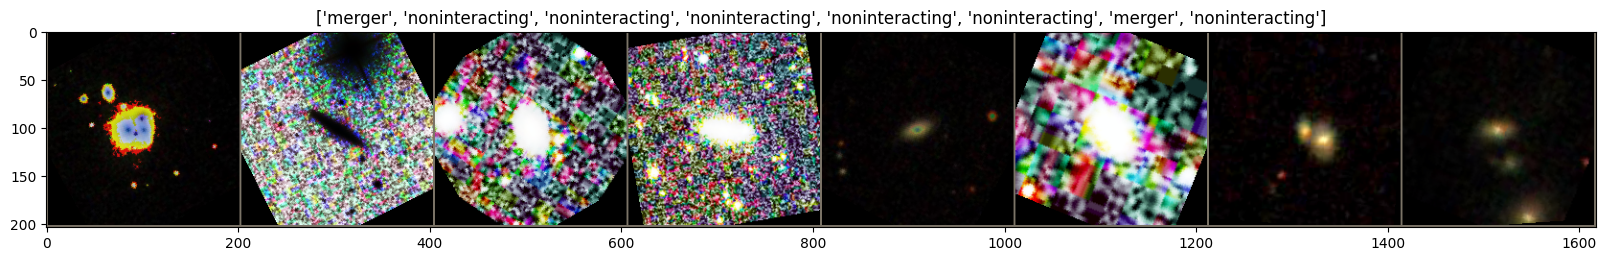

In [16]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20, 60))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [17]:
class_names

['merger', 'noninteracting']

In [18]:
dataset_sizes

{'test': 3998, 'train': 8003, 'val': 3999}

<Figure size 1500x4000 with 0 Axes>

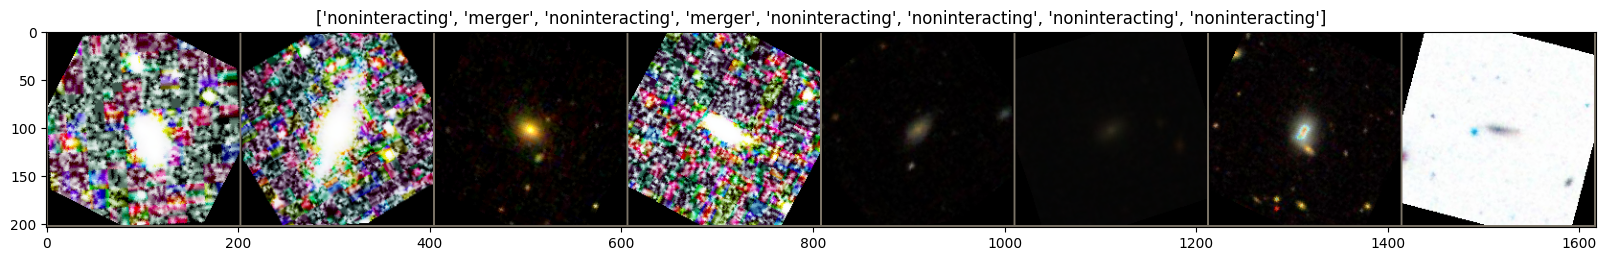

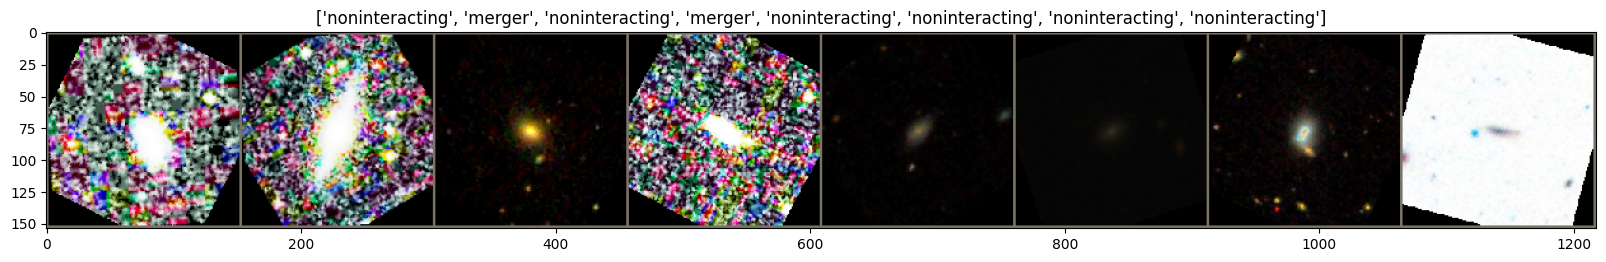

<Figure size 1500x4000 with 0 Axes>

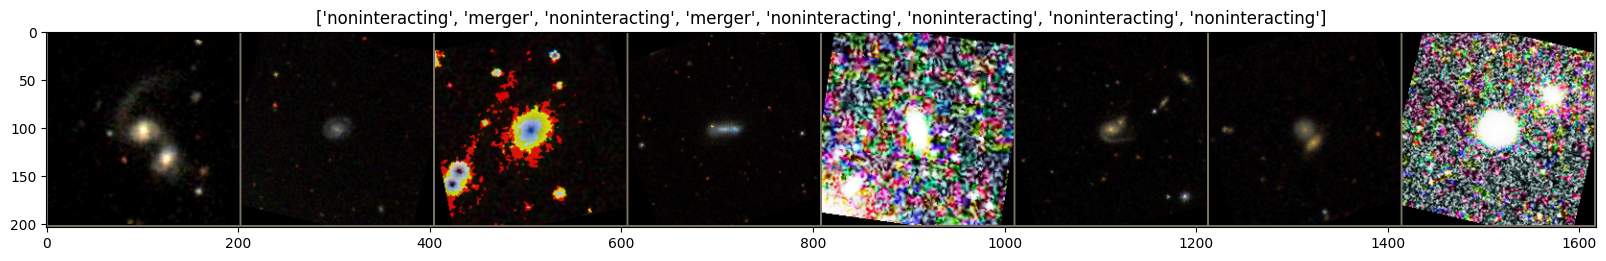

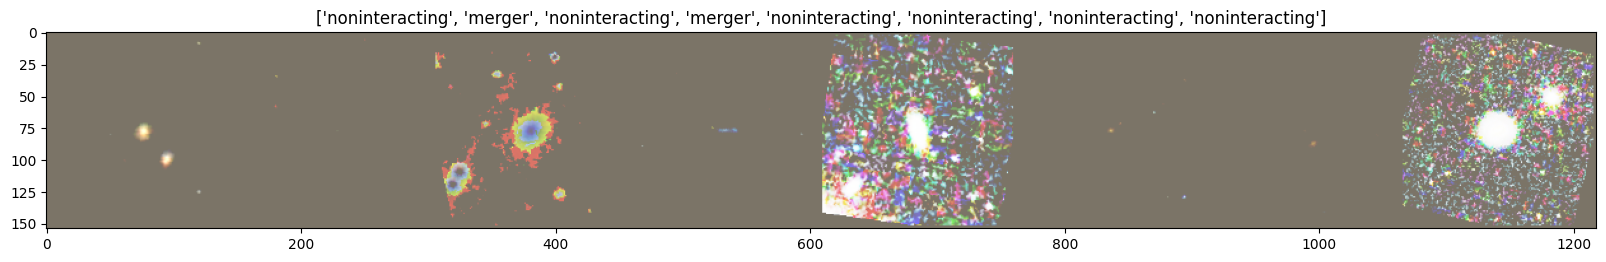

In [19]:
# Visualize the effect of downsampling
inputs, classes = next(iter(dataloaders['train']))

def downsample_check(size=150, mode="nearest"):
  inputs, labels = next(iter(dataloaders['train']))
  
  plt.figure(figsize=(15, 40))
  # "Original (top) vs Downsampled (bottom)"

  if mode == "nearest":
    # Observation: There's significant difference between clamping and not clamping.
    intrp_inps = F.interpolate(inputs, size=size, mode=mode)
  elif mode == "bicubic":
    intrp_inps = F.interpolate(inputs, size=size, mode=mode, align_corners=True).clamp(min=0, max=255)

  out_intrp = torchvision.utils.make_grid(intrp_inps)
  out = torchvision.utils.make_grid(inputs)

  imshow(out, title=[class_names[x] for x in classes])
  imshow(out_intrp, title=[class_names[x] for x in classes])

downsample_check()
downsample_check(mode="bicubic")

In [20]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(1152, 288)
        self.fc2 = nn.Linear(288, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        # clamp is required due to the nature of bicubic interpolation. See "Note" in https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html#torch.nn.functional.interpolate
        x = F.interpolate(x, size=(150, 150), mode="bicubic", align_corners=True)
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        # x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.dropout(x)
        # x = self.pool(x)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Model()
model = model.to(device)

In [21]:
model

Model(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=1152, out_features=288, bias=True)
  (fc2): Linear(in_features=288, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

In [22]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20)  # After every 20 epochs, decrease the lr by `gamma` (= 0.1 by default)

epochs = 50

In [23]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    epochs_no_improve = 0  # Track how many epochs with no decrease in validation loss
    n_epochs_stop = 6  # Stop if no decrement in validation loss after 5 consecutive epochs.
    early_stop = False
    min_val_loss = np.Inf

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Training mode
            else:
                model.eval()   # Evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):    
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                  loss.backward()
                  optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            ### EARLY STOPPING ###
            if phase == "val" and epoch_loss < min_val_loss:
              epochs_no_improve = 0
              min_val_loss = epoch_loss
            elif phase == "val" and epoch_loss >= min_val_loss:
              epochs_no_improve += 1
            
            if epoch > 5 and (epochs_no_improve == n_epochs_stop):
              print("Early stopping!")
              return  # Way to come out of all nested loops
            
            ### end ###

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [24]:
trained_model = train_model(model, criterion, optimizer, scheduler=scheduler, num_epochs=epochs)

Epoch 0/49
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.6635 Acc: 0.6223
val Loss: 0.6613 Acc: 0.6252

Epoch 1/49
----------
train Loss: 0.6594 Acc: 0.6250
val Loss: 0.6599 Acc: 0.6252

Epoch 2/49
----------
train Loss: 0.6383 Acc: 0.6491
val Loss: 0.6574 Acc: 0.6252

Epoch 3/49
----------
train Loss: 0.6114 Acc: 0.6775
val Loss: 0.5864 Acc: 0.6732

Epoch 4/49
----------
train Loss: 0.5914 Acc: 0.6987
val Loss: 0.5899 Acc: 0.6952

Epoch 5/49
----------
train Loss: 0.5484 Acc: 0.7377
val Loss: 0.4101 Acc: 0.8380

Epoch 6/49
----------
train Loss: 0.5219 Acc: 0.7586
val Loss: 0.3920 Acc: 0.8442

Epoch 7/49
----------
train Loss: 0.5221 Acc: 0.7541
val Loss: 0.4056 Acc: 0.8260

Epoch 8/49
----------
train Loss: 0.4926 Acc: 0.7753
val Loss: 0.3744 Acc: 0.8387

Epoch 9/49
----------
train Loss: 0.4695 Acc: 0.7891
val Loss: 0.3342 Acc: 0.8730

Epoch 10/49
----------
train Loss: 0.4644 Acc: 0.7928
val Loss: 0.3010 Acc: 0.8897

Epoch 11/49
----------
train Loss: 0.5471 Acc: 0.7206
val Loss: 0.3270 Acc: 0.8770

Epoch 12/49
----------
t

In [25]:
# Testing loop
test_loader = dataloaders["test"]
correct, total = 0, 0

all_preds = []
all_targets = []
outs = []

model.eval()  # Set model to evaluation mode.
with torch.no_grad():
  
  # Iterate over the test data and generate predictions
  for i, data in enumerate(test_loader, 0):
    
    # Get inputs
    inputs, targets = data

    inputs = inputs.to(device)
    targets = targets.to(device)
    
    # Generate outputs
    outputs = model(inputs)
    
    # Set total and correct
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

    all_preds.append(predicted)
    all_targets.append(targets)
    outs.append(outputs.data)
    
  # Print accuracy
  print(f"Accuracy: {100 * correct / total}")

Accuracy: 91.17058529264632


In [26]:
preds_ = np.concatenate([pred.cpu().numpy() for pred in all_preds])

In [27]:
preds_

array([0, 0, 1, ..., 1, 1, 1])

In [28]:
targets_ = np.concatenate([target.cpu().numpy() for target in all_targets])

In [29]:
from sklearn.metrics import  confusion_matrix, classification_report

In [30]:
print(confusion_matrix(targets_, preds_))
print("\n")
print(classification_report(targets_, preds_))

[[1227  271]
 [  82 2418]]


              precision    recall  f1-score   support

           0       0.94      0.82      0.87      1498
           1       0.90      0.97      0.93      2500

    accuracy                           0.91      3998
   macro avg       0.92      0.89      0.90      3998
weighted avg       0.91      0.91      0.91      3998



In [31]:
!pip install plot-metric

In [32]:
from plot_metric.functions import BinaryClassification

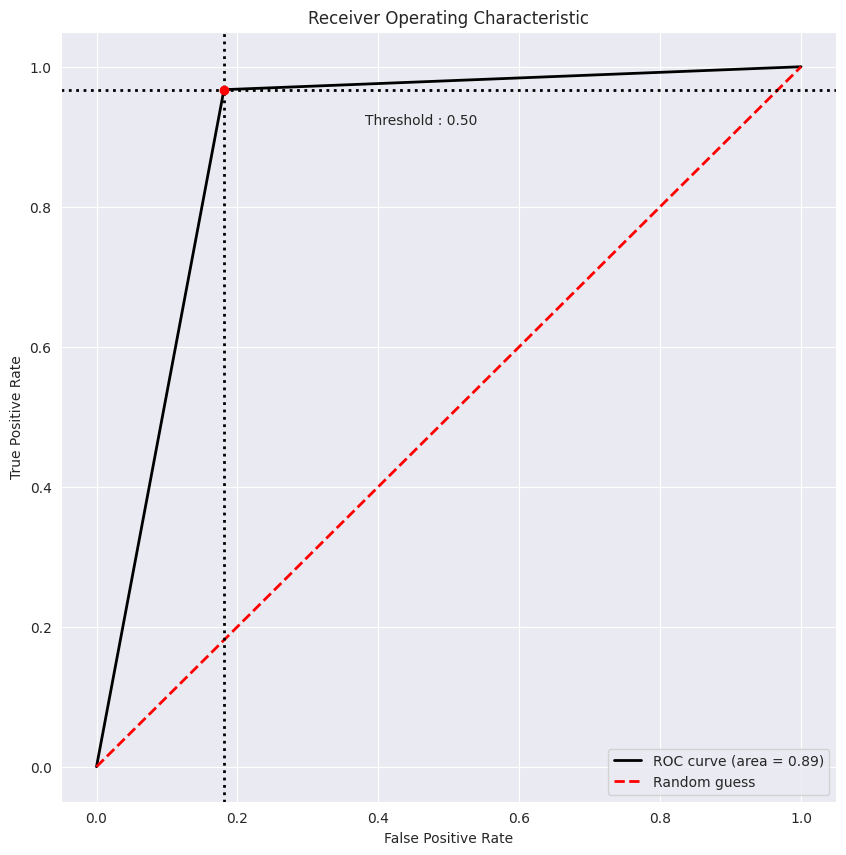

In [33]:
# Visualisation with plot_metric
bc = BinaryClassification(targets_, preds_, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve()
plt.show()